In [2]:
import importdata
from sklearn.decomposition import PCA
import MachineLearning as ML
import MLAnalysis as MLA
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import scipy.stats as stats
import time

In [3]:
data = importdata.importdata(mask_rad30=True, mask_chisq0=True)

/home/alan/mega/AstroTechniques/margaret/notebooks/importdata.py:141: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  catalog = catalog[mask_chisq]


In [7]:
data.columns.values

array(['RELEASE', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR',
       'EBV', 'FLUX_U', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_Y',
       'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_U',
       'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_I', 'FLUX_IVAR_Z',
       'FLUX_IVAR_Y', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3',
       'FLUX_IVAR_W4', 'MW_TRANSMISSION_U', 'MW_TRANSMISSION_G',
       'MW_TRANSMISSION_R', 'MW_TRANSMISSION_I', 'MW_TRANSMISSION_Z',
       'MW_TRANSMISSION_Y', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2',
       'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_U', 'NOBS_G',
       'NOBS_R', 'NOBS_I', 'NOBS_Z', 'NOBS_Y', 'NOBS_W1', 'NOBS_W2',
       'NOBS_W3', 'NOBS_W4', 'RCHISQ_U', 'RCHISQ_G', 'RCHISQ_R',
       'RCHISQ_I', 'RCHISQ_Z', 'RCHISQ_Y', 'RCHISQ_W1', 'RCHISQ_W2',
       'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_U', 'FRACFLUX_G', 'FRACFLUX_R',
       'FRACFLUX_I', 'FRACFLUX_Z', 'FRACFLUX_Y', 'FRACFLUX_W1',
       'FRACFLUX_W2', 'FRACFLUX_

In [7]:
def predict(input_names, target_name, func=ML.Regressors.KNN_dregressor, apply_pca=False, data_slice=slice(None)):
    t0 = time.time()
    inputs, target = data[input_names], data[target_name]
    reg = ML.Regressors(inputs, target, apply_pca=apply_pca)
    result = func(reg)
    print(f"Running {func.__name__} took {time.time()-t0} seconds")
    return result, reg

ALL_NAMES = ["gminr", "rminz", "zminw1", "w1minw2", "rmag", "radius", "expscale"]
def all_names_except(leaveout):
    names = ALL_NAMES.copy()
    names.remove(leaveout)
    return names

In [8]:
input_names_trials = [all_names_except(name) for name in ALL_NAMES]
target_name = "redshift"

results = [predict(names, target_name) for names in input_names_trials]

Running KNN_dregressor took 37.90912652015686 seconds
Running KNN_dregressor took 38.848461627960205 seconds
Running KNN_dregressor took 34.20181608200073 seconds
Running KNN_dregressor took 33.320144176483154 seconds
Running KNN_dregressor took 34.36817002296448 seconds
Running KNN_dregressor took 34.2250452041626 seconds
Running KNN_dregressor took 20.935343265533447 seconds


NameError: name 'results_pca' is not defined

In [9]:
input_names_trials = [all_names_except(name) for name in ALL_NAMES]
target_name = "redshift"

results_pca = [predict(names, target_name, apply_pca=True) for names in input_names_trials]

Running KNN_dregressor took 34.984288454055786 seconds
Running KNN_dregressor took 30.086834192276 seconds
Running KNN_dregressor took 33.47538924217224 seconds
Running KNN_dregressor took 31.667632579803467 seconds
Running KNN_dregressor took 33.96467471122742 seconds
Running KNN_dregressor took 34.15888690948486 seconds
Running KNN_dregressor took 21.21702218055725 seconds


In [10]:
def f(z):
    return 1+z
for result,reg in [*results, *results_pca]:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    reg.test = {
        "r2": analysis.r2(),
        "nmad": analysis.nmad(),
        "outliers": analysis.outlier_frac()
    }

No PCA:


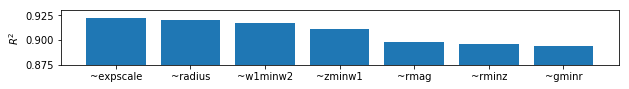

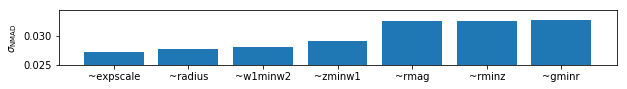

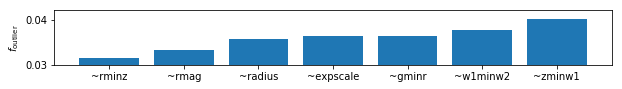

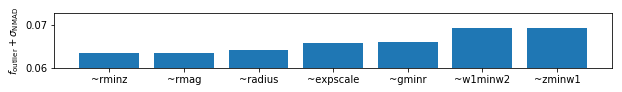

With PCA:


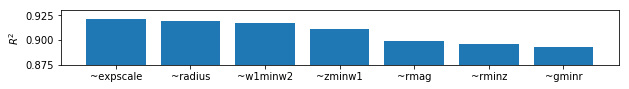

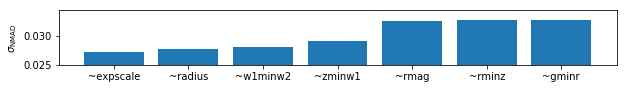

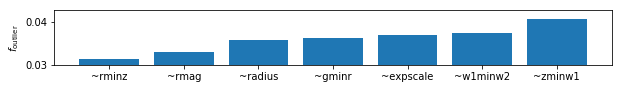

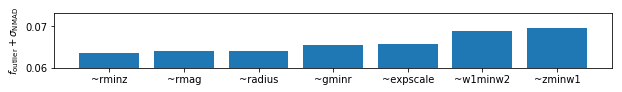

In [13]:
def plot_results(results):
    results, regs = zip(*results)
    x = np.array(["~"+name for name in ALL_NAMES] + ["all"])
    argr = np.argsort([reg.test["r2"] for reg in regs])[::-1]
    argn = np.argsort([reg.test["nmad"] for reg in regs])
    argo = np.argsort([reg.test["outliers"] for reg in regs])
    arg2 = np.argsort([reg.test["outliers"] + reg.test["nmad"] for reg in regs])

    plt.figure(figsize=(10,1))
    plt.bar(x[argr],np.array([reg.test["r2"] for reg in regs])[argr]); plt.ylim([.875,.93]); plt.ylabel("$R^2$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argn],np.array([reg.test["nmad"] for reg in regs])[argn]); plt.ylim(bottom=.025); plt.ylabel("$\\sigma_{\\rm NMAD}$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argo],np.array([reg.test["outliers"] for reg in regs])[argo]); plt.ylim(bottom=.03); plt.ylabel("$f_{\\rm outlier}$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argo],np.array([reg.test["outliers"] + reg.test["nmad"] for reg in regs])[arg2]); plt.ylim(bottom=.06); plt.ylabel("$f_{\\rm outlier} + \\sigma_{\\rm NMAD}$")

print("No PCA:")
plot_results(results); plt.show()
print("With PCA:")
plot_results(results_pca)

# Below is the result obtained without selecting radius < 30

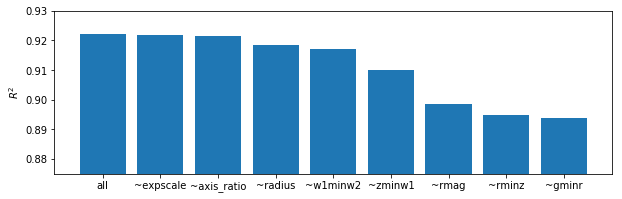

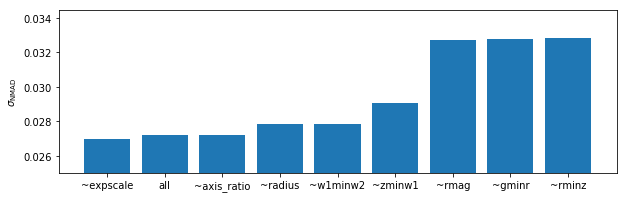

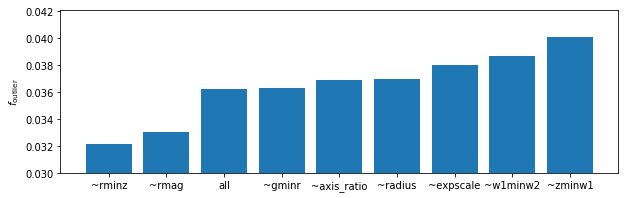

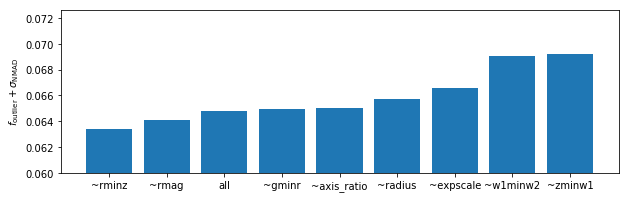

In [62]:
x = np.array(["~"+name for name in ALL_NAMES] + ["all"])
argr = np.argsort([result["r2"][0] for result in results])[::-1]
argn = np.argsort([result["nmad"][0] for result in results])
argo = np.argsort([result["outliers"][0] for result in results])
arg2 = np.argsort([result["outliers"][0] + result["nmad"][0] for result in results])

plt.figure(figsize=(10,3))
plt.bar(x[argr],np.array([result["r2"][0] for result in results])[argr]); plt.ylim([.875,.93]); plt.ylabel("$R^2$")
plt.figure(figsize=(10,3))
plt.bar(x[argn],np.array([result["nmad"][0] for result in results])[argn]); plt.ylim(bottom=.025); plt.ylabel("$\\sigma_{\\rm NMAD}$");
plt.figure(figsize=(10,3))
plt.bar(x[argo],np.array([result["outliers"][0] for result in results])[argo]); plt.ylim(bottom=.03); plt.ylabel("$f_{\\rm outlier}$");
plt.figure(figsize=(10,3))
plt.bar(x[argo],np.array([result["outliers"][0] + result["nmad"][0] for result in results])[arg2]); plt.ylim(bottom=.06); plt.ylabel("$f_{\\rm outlier} + \\sigma_{\\rm NMAD}$");

Running RFregressor took 93.53373432159424 seconds
Running KNNregressor took 18.17453694343567 seconds
Running KNN_dregressor took 19.28568983078003 seconds


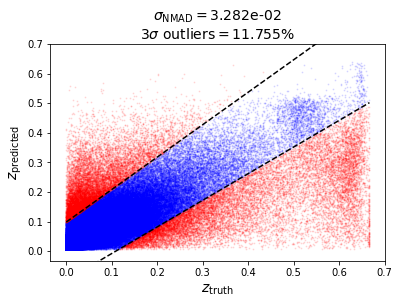

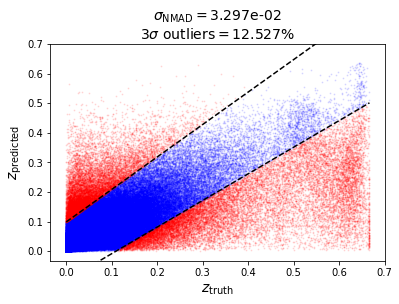

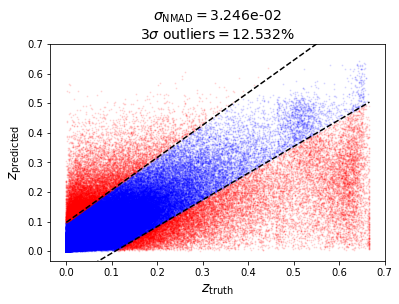

In [27]:
input_names = ["gminr", "rminz", "zminw1", "w1minw2", "gmag", "prob_exp"]
target_name = "b1000"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func, data_slice=mask_chisq) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

Running RFregressor took 103.13085603713989 seconds
Running KNNregressor took 6.745930433273315 seconds
Running KNN_dregressor took 31.172248601913452 seconds


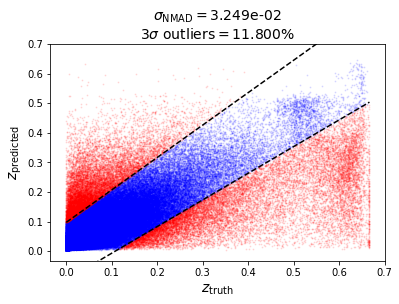

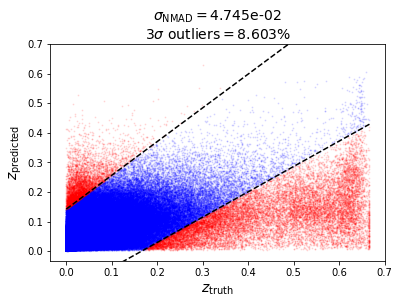

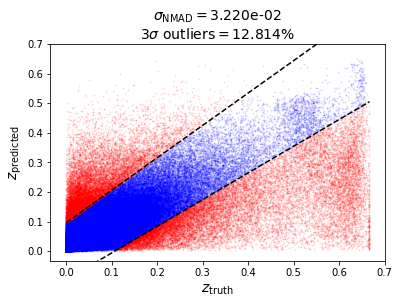

In [28]:
input_names = ["gminr", "rminz", "zminw1", "w1minw2", "gmag", "expscale"]
target_name = "b1000"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

Running RFregressor took 95.89278054237366 seconds
Running KNNregressor took 12.307918310165405 seconds
Running KNN_dregressor took 23.21302628517151 seconds


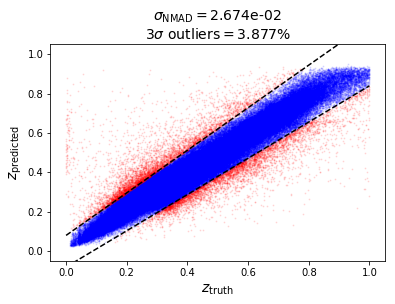

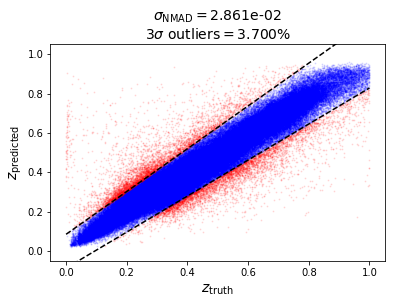

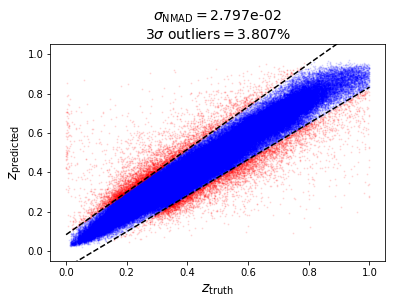

In [20]:
input_names = ["gminr", "rminz", "zminw1", "w1minw2", "gmag", "p_exp"]
target_name = "redshift"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

Running RFregressor took 88.39898228645325 seconds
Running KNNregressor took 13.181779384613037 seconds
Running KNN_dregressor took 16.232118606567383 seconds


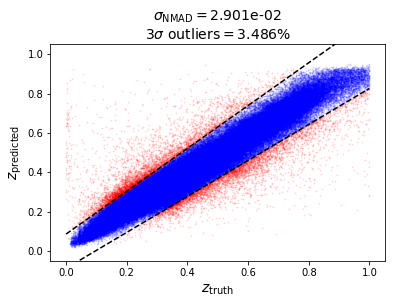

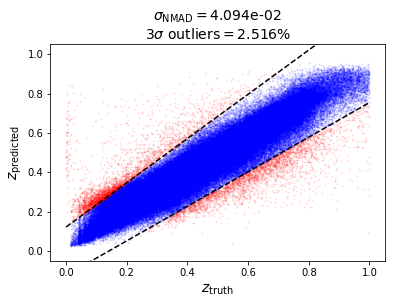

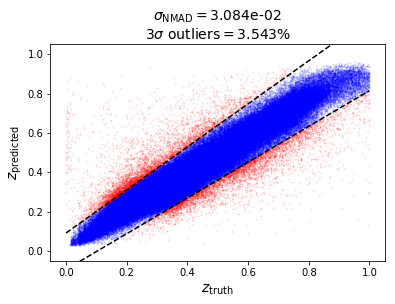

In [21]:
input_names = ["gmag", "rmag", "zmag", "w1mag", "w2mag", "logprob_exp"]
target_name = "redshift"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

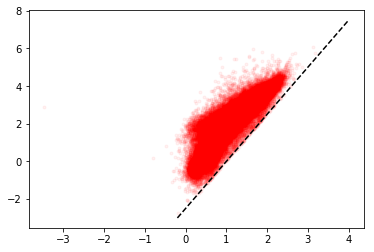

In [22]:
def plot_line(m,b):
    x = np.linspace(-.2,4)
    y = m*x + b
    plt.plot(x,y,"k--")
x,y = data["rmag"]-data["zmag"], data["rmag"]-data["w1mag"]
is_star = y < 2.5 * x - 2.5
plt.plot(x[is_star],y[is_star], "b.", alpha=.05)
plt.plot(x[~is_star],y[~is_star], "r.", alpha=.05)
plot_line(2.5,-2.5)


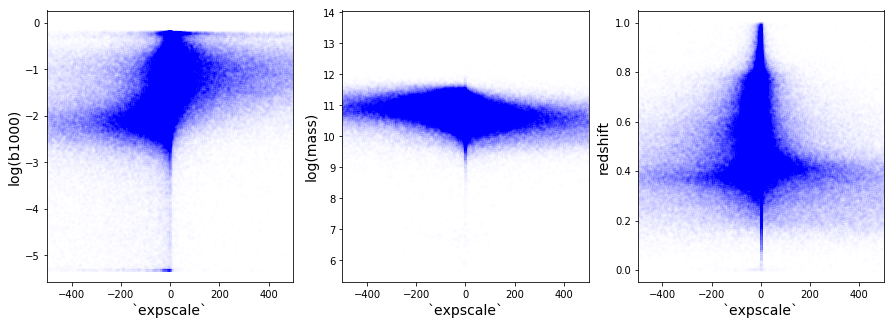

In [21]:
fig,axes = plt.subplots(figsize=(15,5), ncols=3)
[ax.set_xlim((-500,500)) for ax in axes]
[ax.set_xlabel("`expscale`", fontsize=14) for ax in axes]
axes[0].plot(data.expscale, np.log10(data.b1000), "b.", alpha=.005); axes[0].set_ylabel("log(b1000)", fontsize=14)
axes[1].plot(data.expscale, data.mass_ir, "b.", alpha=.005); axes[1].set_ylabel("log(mass)", fontsize=14)
axes[2].plot(data.expscale, data.redshift, "b.", alpha=.005); axes[2].set_ylabel("redshift", fontsize=14);

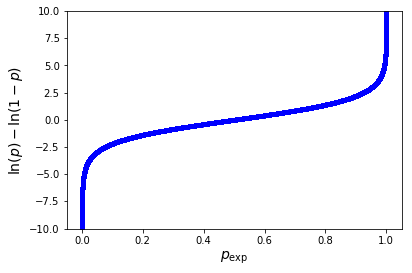

In [81]:
plt.plot(data.prob_exp, data.expscale, "b."); plt.ylim([-10,10]); plt.xlabel("$p_{\\rm exp}$", fontsize=14)
plt.ylabel("$\\ln(p)-\\ln(1-p)$", fontsize=14);

In [109]:
ALL_NAMES

['gminr', 'rminz', 'zminw1', 'w1minw2', 'rmag', 'radius', 'expscale']

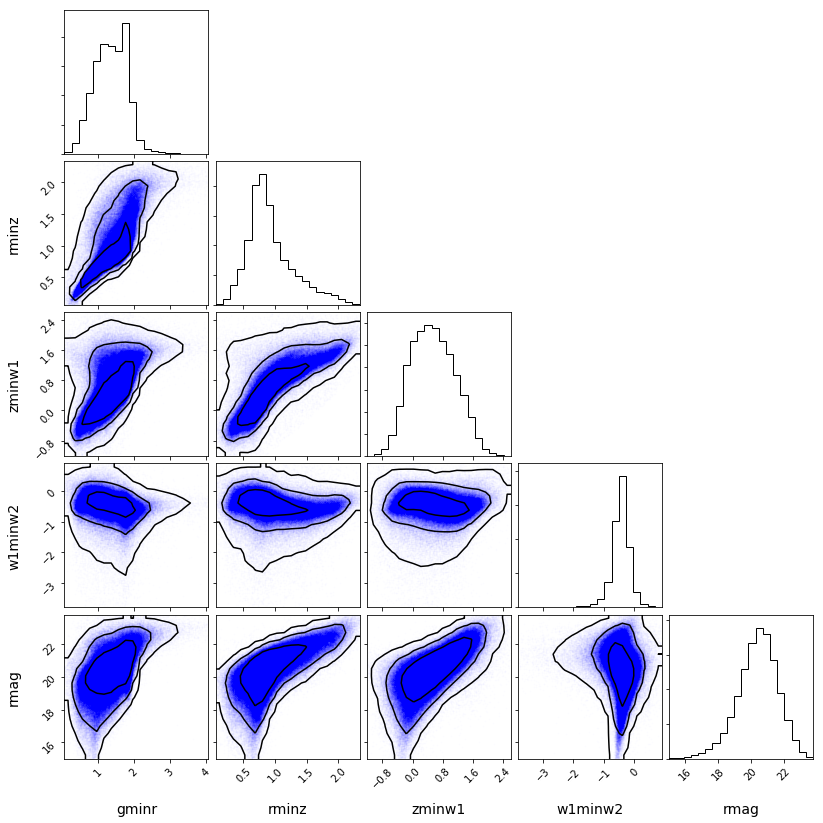

In [137]:
corner.corner(data[data.radius<30][ALL_NAMES[:-2]].values, no_fill_contours=True, plot_density=False, labels=ALL_NAMES, 
              label_kwargs={"fontsize":14}, range=[.999,.999,.999,.999,.999],#,.99,.97], 
              data_kwargs={"alpha":.01, "color":"blue"}, levels=[.68,.95,.995]);

In [139]:
pca = PCA()
pca = PCA(n_components=len(ALL_NAMES[:-2]))
principalComponents = pca.fit_transform(data[data.radius<30][ALL_NAMES[:-2]].values)

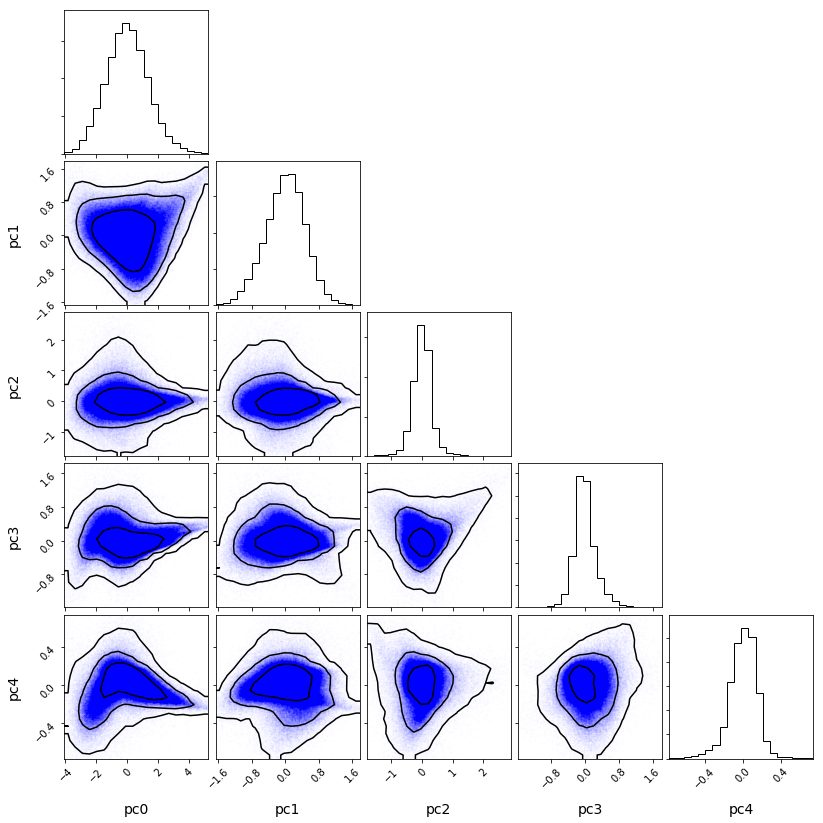

In [140]:
#principalComponents = pca.transform(data[data.radius<30][ALL_NAMES].values)
corner.corner(principalComponents, no_fill_contours=True, plot_density=False, 
              labels=[f"pc{i}" for i in range(len(ALL_NAMES))], label_kwargs={"fontsize":14}, 
              range=[.999,.999,.999,.999,.999], data_kwargs={"alpha":.01, "color":"blue"},
              levels=[.68,.95,.995]);

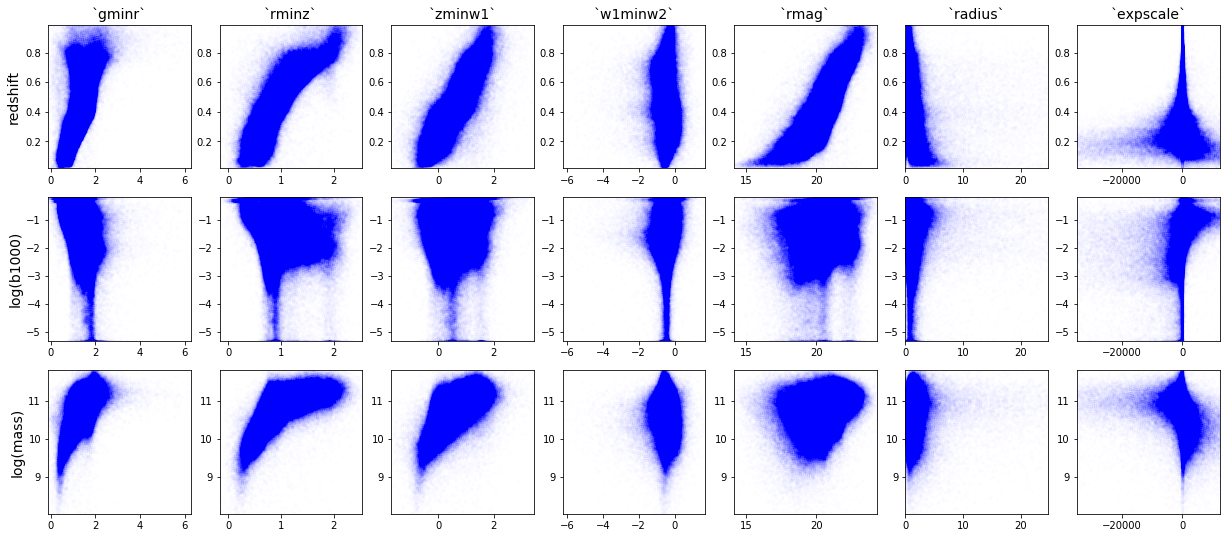

In [154]:
ZRANGE = np.percentile(data.redshift, [.05, 99.95])
MRANGE = np.percentile(np.log10(data.b1000), [.05, 99.95])
BRANGE = np.percentile(data.mass_ir, [.05, 99.95])
def plot_feature(feature, name, axes, range):
    dq = (1-range)*50.
    xrange = np.percentile(feature, [dq, 100-dq])
    [ax.set_xlim(xrange) for ax in axes]
    axes[0].plot(feature, data.redshift, "b.", alpha=.005); axes[0].set_ylim(ZRANGE)
    axes[1].plot(feature, np.log10(data.b1000), "b.", alpha=.005); axes[1].set_ylim(MRANGE)
    axes[2].plot(feature, data.mass_ir, "b.", alpha=.005); axes[2].set_ylim(BRANGE)

def make_feature_plot(features, names, ranges=None):
    ranges = [.999] * len(features) if ranges is None else ranges
    fig,axes = plt.subplots(figsize=(3*len(features),9), nrows=3, ncols=(len(features)))
    axes[0,0].set_ylabel("redshift", fontsize=14)
    axes[1,0].set_ylabel("log(b1000)", fontsize=14)
    axes[2,0].set_ylabel("log(mass)", fontsize=14)
    [axes[0,i].set_title(f"`{names[i]}`", fontsize=14) for i in range(len(features))]
    for i in range(len(features)):
        plot_feature(features[i], names[i], axes[:,i], ranges[i])

make_feature_plot(data[ALL_NAMES].values.T, ALL_NAMES, [.9999, .9999, .9999, .9999, .9999, .99, .97])

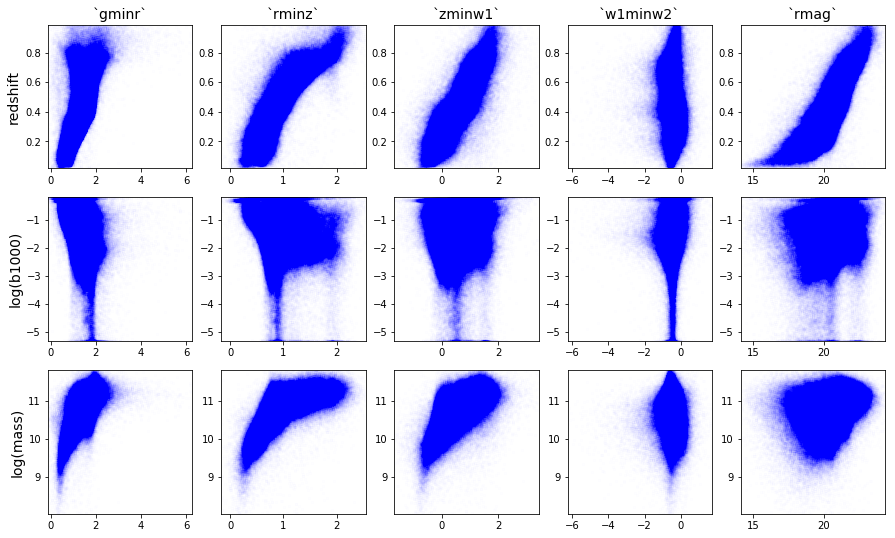

In [157]:
make_feature_plot(data[ALL_NAMES[:-2]].values.T, ALL_NAMES[:-2], [.9999, .9999, .9999, .9999, .9999])

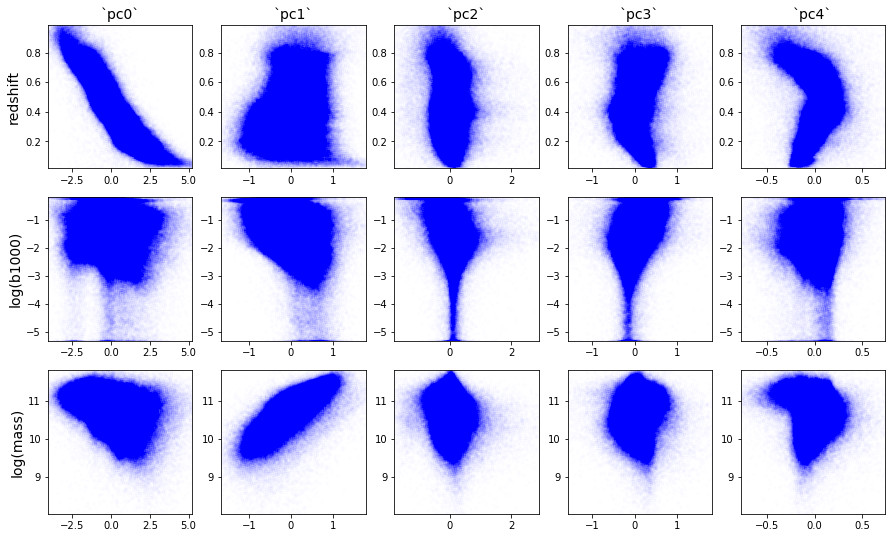

In [161]:
make_feature_plot(principalComponents.T, [f"pc{i}" for i in range(5)], [.999, .999, .999, .999, .999])